# **Waze Project**

# Build a machine learning model

**The purpose** of this model is to find factors that drive user churn.

**The goal** of this model is to predict whether or not a Waze user is retained or churned.

### Imports and data loading

In [ ]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# This is the function that helps plot feature importance
from xgboost import plot_importance

# # This module lets us save our models once we fit them.
import pickle

In [ ]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [ ]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### Feature engineering
To begin, create a copy of `df0` to preserve the original dataframe. Call the copy `df`.

In [ ]:
# Copy the df0 dataframe
df = df0.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

In [ ]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [ ]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['km_per_driving_day'].replace(np.inf, 0)

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

In [ ]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions']/df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [ ]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives']>=60) & (df['driving_days']>=15), 1, 0)
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0


#### **`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [ ]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions']/df['n_days_after_onboarding']

In [ ]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [ ]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives']/(df['duration_minutes_drives']/60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [ ]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives']/df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [ ]:
# 1. Convert infinite values to zero
df['km_per_drive'] = df['km_per_drive'].replace(np.inf, 0)

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [ ]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2'])/df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### Drop missing values


In [ ]:
# Drop rows with missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14299 non-null  int64  
 1   label                           14299 non-null  object 
 2   sessions                        14299 non-null  int64  
 3   drives                          14299 non-null  int64  
 4   total_sessions                  14299 non-null  float64
 5   n_days_after_onboarding         14299 non-null  int64  
 6   total_navigations_fav1          14299 non-null  int64  
 7   total_navigations_fav2          14299 non-null  int64  
 8   driven_km_drives                14299 non-null  float64
 9   duration_minutes_drives         14299 non-null  float64
 10  activity_days                   14299 non-null  int64  
 11  driving_days                    14299 non-null  int64  
 12  device                          14299

### Outliers

From previous EDA it is known that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### Variable encoding

#### **Dummying features**

Create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [ ]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0


#### **Target encoding**

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` so as not to overwrite the original `label` variable.

In [ ]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='retained', 0, 1)
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0,0.106009,123.147688,8.749890,0.000000,1,0
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0,0.657570,433.471306,2624.586414,0.857534,1,0
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0,0.058711,191.944326,225.487213,0.000000,1,0
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0,0.432859,99.791944,57.645864,0.141665,0,0
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0,0.081682,154.838864,88.874416,0.294115,1,1


### Feature selection

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

In [ ]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


In [ ]:
df = df.drop(['device'], axis=1)
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


### Evaluation metric

In [ ]:
# Get class balance of 'label' col
df['label2'].value_counts(normalize=True)

label2
0    0.822645
1    0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

### Modeling workflow and model selection process

### Split the data

In [ ]:
# 1. Isolate X variables
X = df.drop(['label', 'label2'], axis=1)

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

Verify the number of samples in the partitioned data.

In [ ]:
print('train set:' + str(len(X_tr)))
print('validation set:' + str(len(X_val)))
print('test set:' + str(len(X_test)))

train set:8579
validation set:2860
test set:2860


In [ ]:
y_tr.value_counts()

label2
0    7057
1    1522
Name: count, dtype: int64

This aligns with expectations.

In [ ]:
y_val.value_counts()

label2
0    2353
1     507
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

label2
0    2353
1     507
Name: count, dtype: int64

### Modeling

#### **Random forest**

In [ ]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# 2. Create a dictionary of hyperparameters to tune

cv_params = {'max_depth': [None],
             'max_features': [1.0,2.0],
             'max_samples': [1.0,2.0],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [300],
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [ ]:
rf_cv.fit(X_tr, y_tr)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None], 'max_features': [1.0, 2.0],
                         'max_samples': [1.0, 2.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [ ]:
# Examine best score
rf_cv.best_score_

0.1346715706589308

In [ ]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

This function is provided for you, but if you'd like to challenge yourself, try writing your own function!

In [ ]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [ ]:
rf_results = make_results('Random forest', rf_cv, 'recall')
rf_results

,model,precision,recall,F1,accuracy
0,Random forest,0.488875,0.134672,0.210912,0.821657


#### **XGBoost**

In [ ]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
params = { 'max_depth': [5, 7],
          'min_child_weight': [1, 3],
          'learning_rate':[0.01, 0.1],
          'n_estimators':[300]
         }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [ ]:
xgb_cv.fit(X_tr, y_tr)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'max_depth': [None], 'max_features': [1.0, 2.0],
                         'max_samples': [1.0, 2.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [ ]:
# Examine best score
xgb_cv.best_score_

0.18202617764884654

In [ ]:
# Examine best parameters
xgb_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
# Call 'make_results()' on the GridSearch object
xgb_results = make_results('XGBoost', xgb_cv, 'recall')
results = pd.concat([rf_results, xgb_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random forest,0.488875,0.134672,0.210912,0.821657
0,XGBoost,0.406251,0.182026,0.251175,0.807787


### Model selection

#### **Random forest**

In [ ]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [ ]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [ ]:
# Get validation scores for RF model
rf_val = get_test_scores('Random forest validation',rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random forest,0.488875,0.134672,0.210912,0.821657
0,XGBoost,0.406251,0.182026,0.251175,0.807787
0,Random forest validation,0.471014,0.128205,0.201550,0.819930


#### **XGBoost**

In [ ]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val = get_test_scores('XGBoost validation', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random forest,0.488875,0.134672,0.210912,0.821657
0,XGBoost,0.406251,0.182026,0.251175,0.807787
0,Random forest validation,0.471014,0.128205,0.201550,0.819930
0,XGBoost validation,0.416309,0.191321,0.262162,0.809091


### Use champion model to predict on test data

In [ ]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test = get_test_scores('XGBoost test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random forest,0.488875,0.134672,0.210912,0.821657
0,XGBoost,0.406251,0.182026,0.251175,0.807787
0,Random forest validation,0.471014,0.128205,0.201550,0.819930
0,XGBoost validation,0.416309,0.191321,0.262162,0.809091
0,XGBoost test,0.400000,0.205128,0.271186,0.804545


### Confusion matrix

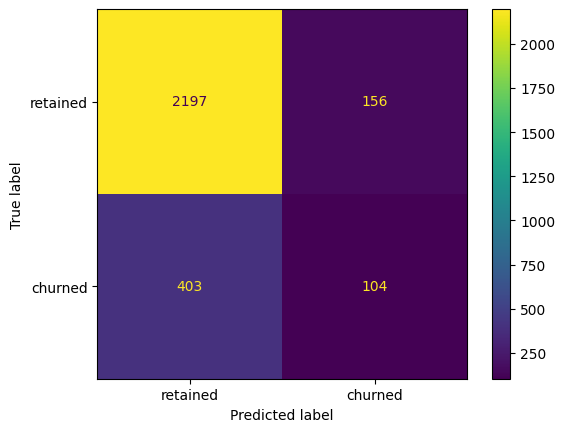

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot()

### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

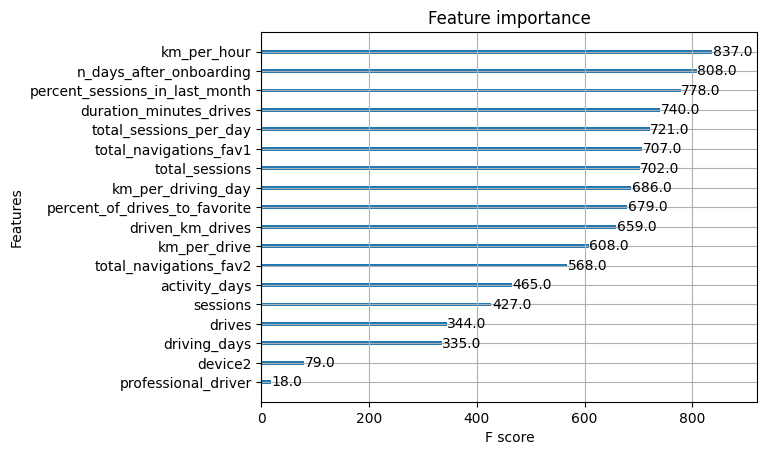

In [ ]:
plot_importance(xgb_cv.best_estimator_)

### Conclusion



1.The recall score was used to choose a champion model. Recall explains the percentage of correctly predicted churned users among  all actually churned users.

2.On validation data random forest model had a recall score of 12.8%, while XGBoost model - 19.1%. On testing data XGBoost showed even better results - 20,5%.

3.Both models had a decent accuracy (82% and 81% respectively). Since there is class imbalance in data (18% user churned and 82% - retained) this score is unsuitable for model evaluation.

4.The most important features of the XGBoost model were the following features:
- km_per_hour;
- number_days_after_onboarding;
- percent_sessions_in_last_month;
- duration_minutes_drives;
- total_sessions_per_day.

5.There are likely to be errors in the initial data. For example, too long driving distance per day, and the number of sessions per month that exceeds the total number of sessions.
